In [164]:
import sys
sys.path.append('/home/lytq/Spatial-Transcriptomics-Benchmark/utils')
from sdmbench import compute_ARI, compute_NMI, compute_CHAOS, compute_PAS, compute_ASW, compute_HOM, compute_COM

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

import warnings
warnings.filterwarnings('ignore')

In [165]:
method = 'BayesSpace'
pred_key = 'spatial.cluster'
umap_keys = ['UMAP1', 'UMAP2']
dataset = 'BRCA1'

data_folder = f'../data/{dataset}'
input_dir = f'../Results/results_old/{dataset}/{method}'
output_dir = f'../Results/results_new/{dataset}/{method}'
os.makedirs(output_dir, exist_ok=True)

file = input_dir
print(method)

BayesSpace


In [166]:
fontsize = 12
def plot_clustering(adata, metrics, out_path, show=True):
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))
    sc.pl.spatial(adata, color='pred', ax=axes, show=False)
    axes.set_title(f'{method} (ARI={metrics["ARI"]:.4f})', fontsize=fontsize, fontweight='bold')
    axes.axis('off')
    axes.set_aspect('auto', adjustable='datalim')
    plt.tight_layout()
    
    plt.savefig(os.path.join(out_path, 'clustering.pdf'), format='pdf', bbox_inches='tight')
    plt.savefig(os.path.join(out_path, 'clustering.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    

def plot_umap(adata, out_path, show=True):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    sc.pl.umap(adata, color='gt', ax=axes[0], show=False)
    sc.pl.umap(adata, color='pred', ax=axes[1], show=False)
    axes[0].set_title('Manual Annotation', fontsize=fontsize)
    axes[1].set_title(method, fontsize=fontsize)
    
    for ax in axes:
        # ax.set_aspect('equal', adjustable='datalim')
        ax.set_aspect('auto', adjustable='datalim')
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(out_path, 'umap.pdf'), format='pdf', bbox_inches='tight')
    plt.savefig(os.path.join(out_path, 'umap.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()

================= Processing BayesSpace BRCA1 =================
    Results saved to ../Results/results_new/BRCA1/BayesSpace
================= Finished BayesSpace BRCA1 =================


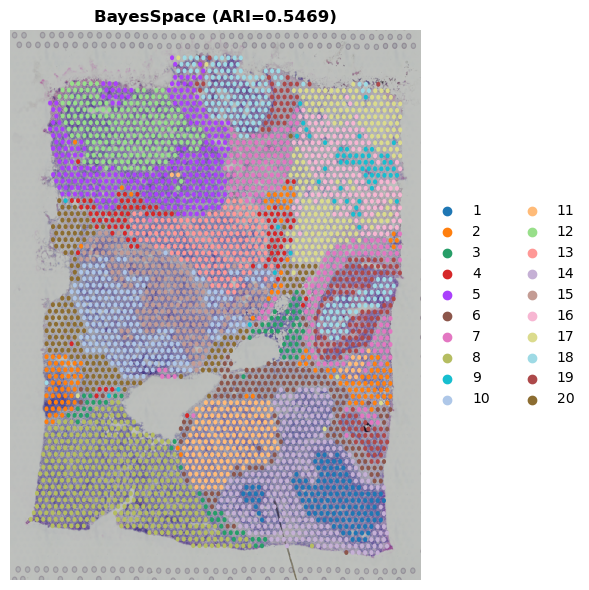

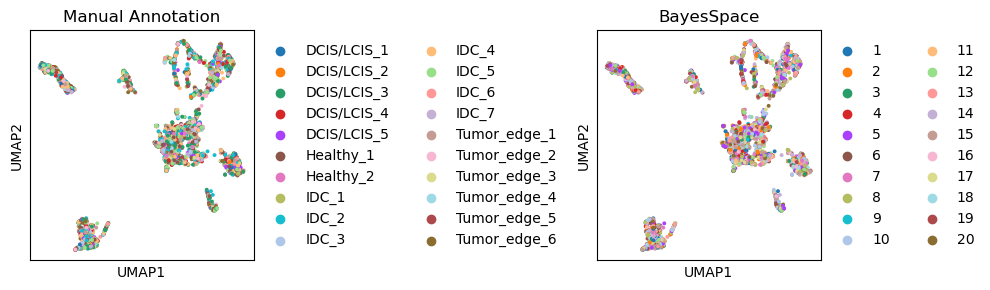

In [167]:
print(f'================= Processing {method} {dataset} =================')
out_path = output_dir
os.makedirs(out_path, exist_ok=True)
section_id = 'V1_Human_Breast_Cancer_Block_A_Section_1'

file_path = os.path.join(data_folder, section_id)

adata = sc.read_visium(file_path)
adata.var_names_make_unique()
metadata = pd.read_csv(file + '/cell_metadata.csv', index_col=0)
gt_metadata = pd.read_csv(os.path.join(file_path, 'metadata.tsv'), sep='\t')


# Sort metadata by index based on adata
metadata = metadata.loc[adata.obs.index]
gt_metadata = gt_metadata.loc[adata.obs.index]

# Match adata and metadata 
# adata = adata[adata.obs.index.isin(metadata.index)]

umap_coords = pd.read_csv(file + '/spatial_umap_coords.csv')
metrics = pd.read_csv(file + '/metrics.csv', index_col=0)

# print(metadata.head())
# print(umap_coords.head())

adata.obs['gt'] = gt_metadata['fine_annot_type'].values
# adata.obs['gt'] = metadata['fine_annot_type'].values
# adata.obs['gt'] = metadata['cluster.init'].values
pred = metadata[pred_key].values
if min(pred) == 0:
    pred += 1

adata.obs['pred'] = pred.astype(str)
adata.obsm['X_umap'] = umap_coords[umap_keys].values
adata = adata[~pd.isnull(adata.obs['gt'])]
adata.obs['gt'] = adata.obs['gt'].astype(str)

time_taken, memmory_used = metrics['Time'].values[0], metrics['Memory'].values[0]
results = {
    'ARI': compute_ARI(adata, 'gt', 'pred'),
    'AMI': compute_NMI(adata, 'gt', 'pred'),
    'Homogeneity': compute_HOM(adata, 'gt', 'pred'),
    'Completeness': compute_COM(adata, 'gt', 'pred'),
    'ASW': compute_ASW(adata, 'pred'),
    'CHAOS': compute_CHAOS(adata, 'pred'),
    'PAS': compute_PAS(adata, 'pred'),
    'Time (s)': time_taken,
    'Memory (MB)': memmory_used
}
df_results = pd.DataFrame([results], index=[method])
df_results.to_csv(os.path.join(out_path, 'metrics.csv'), index=True)

plot_clustering(adata, results, out_path, show=False)
plot_umap(adata, out_path, show=False)
print(f'    Results saved to {out_path}')
# break

print(f'================= Finished {method} {dataset} =================')
# print(df_metrics)

## Combine all metrics

In [174]:
input_dir = f'../Results/results_new/{dataset}'
output_path = f'../Results/results_new/{dataset}/metrics.csv'
input_files = glob.glob(input_dir + '/*')
input_files = [f for f in input_files if os.path.isdir(f)]

all_metrics = []
for file in input_files:
    method = file.split('/')[-1]
    df_metrics = pd.read_csv(os.path.join(file, 'metrics.csv'), index_col=0)
    all_metrics.append(df_metrics)

with open(output_path, 'w') as f:
    for df in all_metrics:
        df.to_csv(f, index=True, header=not f.tell()) 